# Continuous Control

In this notebook we will train a Deep Deterministic Policy Gradient (DDPG) Agent to control a double-jointed arm to move and reach target locations.

In [1]:
# Please uncomment and run the below line if training on Udacity Workspace
#!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


In [2]:
import numpy as np
import torch
from ddpg_agent import Agent
from unityagents import UnityEnvironment
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### Check for GPU device. If not available use CPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


### Create the environment and set the default for controlling

Please change the file name of the environment in case the file path or name is different

In [4]:
# Use this if training on Udacity Workspace
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
# Use this if training Locally
# env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Check the environment for Action and State size

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Helper method to train the agent on the environment

**Parameters:**
* **agent**: An object of the agent class
* **num_agents (int)**: number of parallel agets in the environment
* **n_episodes (int)**: number of episodes
* **max_t (int)**: Maximum number of time step the agent will spend in each episode
* **max_score (float)**: The avg. score in last 100 episodes after which the environment will be considered as solved
* **model_path (str)**: Path to save the trained model

In [6]:
def train(agent, num_agents, n_episodes=5000, max_t=1000, max_score=30.0, model_path='model.pt'):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break
        scores_window.append(np.mean(score))
        scores.append(np.mean(score))
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}")
        if np.mean(scores_window) >= max_score:
            print(f"\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window)}")
            torch.save(agent.actor_local.state_dict(), model_path)
            break
    return scores

### Helper method to visualize the training scores

**Parameters:**

* **scores(list of floats)**: The scores collected for all episodes

In [7]:
def visualize(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Scores')
    plt.xlabel('Episode')
    plt.show()

### Helper method to test a trained agent on the environment

**Parameters**

* **env**: The environmnts
* **agent**: The agent object
* **num_agents (int)**: number of parallel agets in the environment
* **n_episodes(int)**: Number of episodes to run the test
* **model_path**: Path to a saved pytorch model

In [8]:
def test(env, agent, num_agents, n_episodes=3, model_path='model.pt'):
    agent.actor_local.load_state_dict(torch.load(model_path))
    total_score = 0
    for i_episode in range(1, n_episodes+1):
        score = np.zeros(num_agents)
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            score += reward
            state = next_state
            if any(done):
                break
        print(f"\rEpisode {i_episode} \tScore: {np.mean(score)}")
        total_score += np.mean(score)
    print(f"\rAverage score in {n_episodes} episodes: {total_score/n_episodes}")

### Create an agent

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

### Run the training process

Start training the agent and visualize the scores after the completion of the training. In case of any error close the environment.

Episode 100	Average Score: 7.151784840145147
Episode 200	Average Score: 18.758424580716538
Episode 300	Average Score: 22.876184488677417
Episode 368	Average Score: 30.061779328066855
Environment solved in 268 episodes!	Average Score: 30.061779328066855


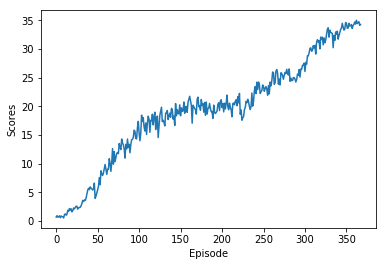

In [10]:
try:
    scores = train(agent, num_agents)
    visualize(scores)
except Exception as e:
    env.close()
    raise e

### Test the agent

Use the trained agent to test the environment.

In [11]:
test(env=env, agent=agent, num_agents=num_agents)

Episode 1 	Score: 34.562499227467924
Episode 2 	Score: 34.45449922988191
Episode 3 	Score: 34.235499234776945
Average score in 3 episodes: 34.41749923070893


### Close the environment after everything is done

In [12]:
env.close()